License
***

Copyright (C) 2017 J. Patrick Hall, jphall@gwu.edu

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

## Simple csv to gdf example
***
* Run all cells to create a gdf from a csv.
* Gdf is suitable for use with Gephi: https://gephi.org/.
* Use Gephi to create correlation/network graph.

### Imports

In [1]:
import re
import time
from IPython.display import Image
from IPython.display import display
import numpy as np
import pandas as pd

### Define user-supplied constants

In [2]:
# absolute Pearson correlation threshold
# above which a pair of correlated variables is written to the gdf
CORR_THRESHOLD = 0.2 

# path at which to read input .csv
IN_FILE = 'train.csv'  

# path at which to write output .gdf
# WARNING: will be over-written!!
OUT_FILE = 'train.gdf'  

# threshold for categorical levels 
# above which a variable will not be encoded 
# and written to the gdf
NUM_LEVELS_THRESHOLD = 25

# input variables to be considered 
# for encoding and writing to gdf
X = ['KitchenAbvGr', 'TotalBsmtSF', 'WoodDeckSF', 'MiscVal', 'OpenPorchSF', 'GarageYrBlt', '2ndFlrSF', '3SsnPorch', 'BsmtFullBath', 'GarageArea', 'Fireplaces', 'YearRemodAdd', 'BsmtFinSF1', 'LowQualFinSF', 'OverallQual', 'BedroomAbvGr', 'FullBath', 'MSSubClass', 'BsmtFinSF2', 'OverallCond', '1stFlrSF', 'YrSold', 'MoSold', 'ScreenPorch', 'BsmtHalfBath', 'YearBuilt', 'LotArea', 'LotFrontage', 'TotRmsAbvGrd', 'GarageCars', 'MasVnrArea', 'HalfBath', 'PoolArea', 'BsmtUnfSF', 'EnclosedPorch', 'GrLivArea', 'Condition2', 'BldgType', 'MSZoning', 'GarageType', 'ExterQual', 'LandSlope', 'SaleType', 'MasVnrType', 'Street', 'BsmtCond', 'BsmtQual', 'Exterior1st', 'Condition1', 'BsmtExposure', 'BsmtFinType2', 'PoolQC', 'FireplaceQu', 'LotShape', 'LandContour', 'Heating', 'SaleCondition', 'Electrical', 'GarageCond', 'GarageFinish', 'Functional', 'Alley', 'Exterior2nd', 'MiscFeature', 'RoofMatl', 'PavedDrive', 'RoofStyle', 'Utilities', 'CentralAir', 'ExterCond', 'GarageQual', 'KitchenQual', 'LotConfig', 'HouseStyle', 'Foundation', 'BsmtFinType1', 'Fence', 'Neighborhood', 'HeatingQC']

### Utility function for writing gdf from Pearson correlation matrix

In [3]:
def write_gdf(corr_frame):

    """ Writes a GDF suitable for use with Gephi: https://gephi.org/.
    
    Args:
        corr_frame: Pandas DataFrame of pair-wise Pearson correlations.
        
    Return: Path of written file.
    
    """
    
    with open(OUT_FILE, 'w+') as out:

        # write node list
        out.write('nodedef>name VARCHAR,label VARCHAR\n')
        for i in range(0, corr_frame.shape[0]):
            out.write(str(i) + ',' + corr_frame.columns[i] + '\n')

        # write edge list
        # edge weight is absolute Pearson correlation
        out.write('edgedef>node1 VARCHAR,node2 VARCHAR, weight DOUBLE\n')
        for i in range(0, corr_frame.shape[0]):
            for j in range(0, corr_frame.shape[1]):
                if i > j:
                    ij_ = np.abs(corr_frame.iat[i, j])
                    if ij_ > CORR_THRESHOLD:
                        out.write(str(i) + ',' + str(j) + ',' + str(ij_) +
                                  '\n')

    return OUT_FILE

### Main routine

In [4]:
def csv2gdf():
    
    """ Encodes categorical variables, calculates Pearson correlations,
        and calls wite_gdf. """

    # read csv and keep inputs in X list
    frame = pd.read_csv(IN_FILE) 
    frame = frame[X]

    # collect names of variables
    # to attempt to encode
    try_name_list = [name for name, type_ in frame[X].dtypes.items()
                     if type_ == 'object']

    print('Encoding categorical columns ...')
    
    # handle unary 
    # don't encode unary categorical columns
    unary_list = [name for name in try_name_list if
                  len(frame[name].unique()) == 1]  
    
    if len(unary_list) > 0:
        frame = frame.drop(unary_list, axis=1)
        try_name_list = list(set(try_name_list) - set(unary_list))
    
    # encode binary
    # don't create perfectly, negatively correlated encoded columns
    binary_list = [name for name in try_name_list if
                   len(frame[name].unique()) == 2] 
    
    if len(binary_list) > 0:
        dummies = pd.get_dummies(frame[binary_list], dummy_na=True,
                                 drop_first=True)
        frame = frame.drop(binary_list, axis=1)
        frame = pd.concat([frame, dummies], axis=1) 
        try_name_list = list(set(try_name_list) - set(binary_list))
    
    # encode nominal
    nominal_list = [name for name in try_name_list if
                    len(frame[name].unique()) <=
                    NUM_LEVELS_THRESHOLD and 
                    len(frame[name].unique()) > 2]

    if len(nominal_list) > 0:
        dummies = pd.get_dummies(frame[nominal_list], dummy_na=True)
        frame = frame.drop(nominal_list, axis=1)
        frame = pd.concat([frame, dummies], axis=1)
    
    print('Done.')

    # calculate Pearson correlations
    print('Calculating Pearson correlations ...')
    corr_frame = frame.corr()
    print('Done.')

    # write gdf
    print('Writing GDF file to %s ...' % write_gdf(corr_frame))
    print('Done.')

    
### execute main routine
csv2gdf()

Encoding categorical columns ...
Done.
Calculating Pearson correlations ...
Done.
Writing GDF file to train.gdf ...
Done.


### Steps to create the graph in Gephi often include:
1. Load the generated GDF ("Open Graph File").
2. Run 'Force Atlas' followed by 'Nooverlap' graph layouts.
3. Run a graph modularity calculation and color nodes by modularity class.
4. Size nodes based on degree.
5. Save a PNG of the graph.

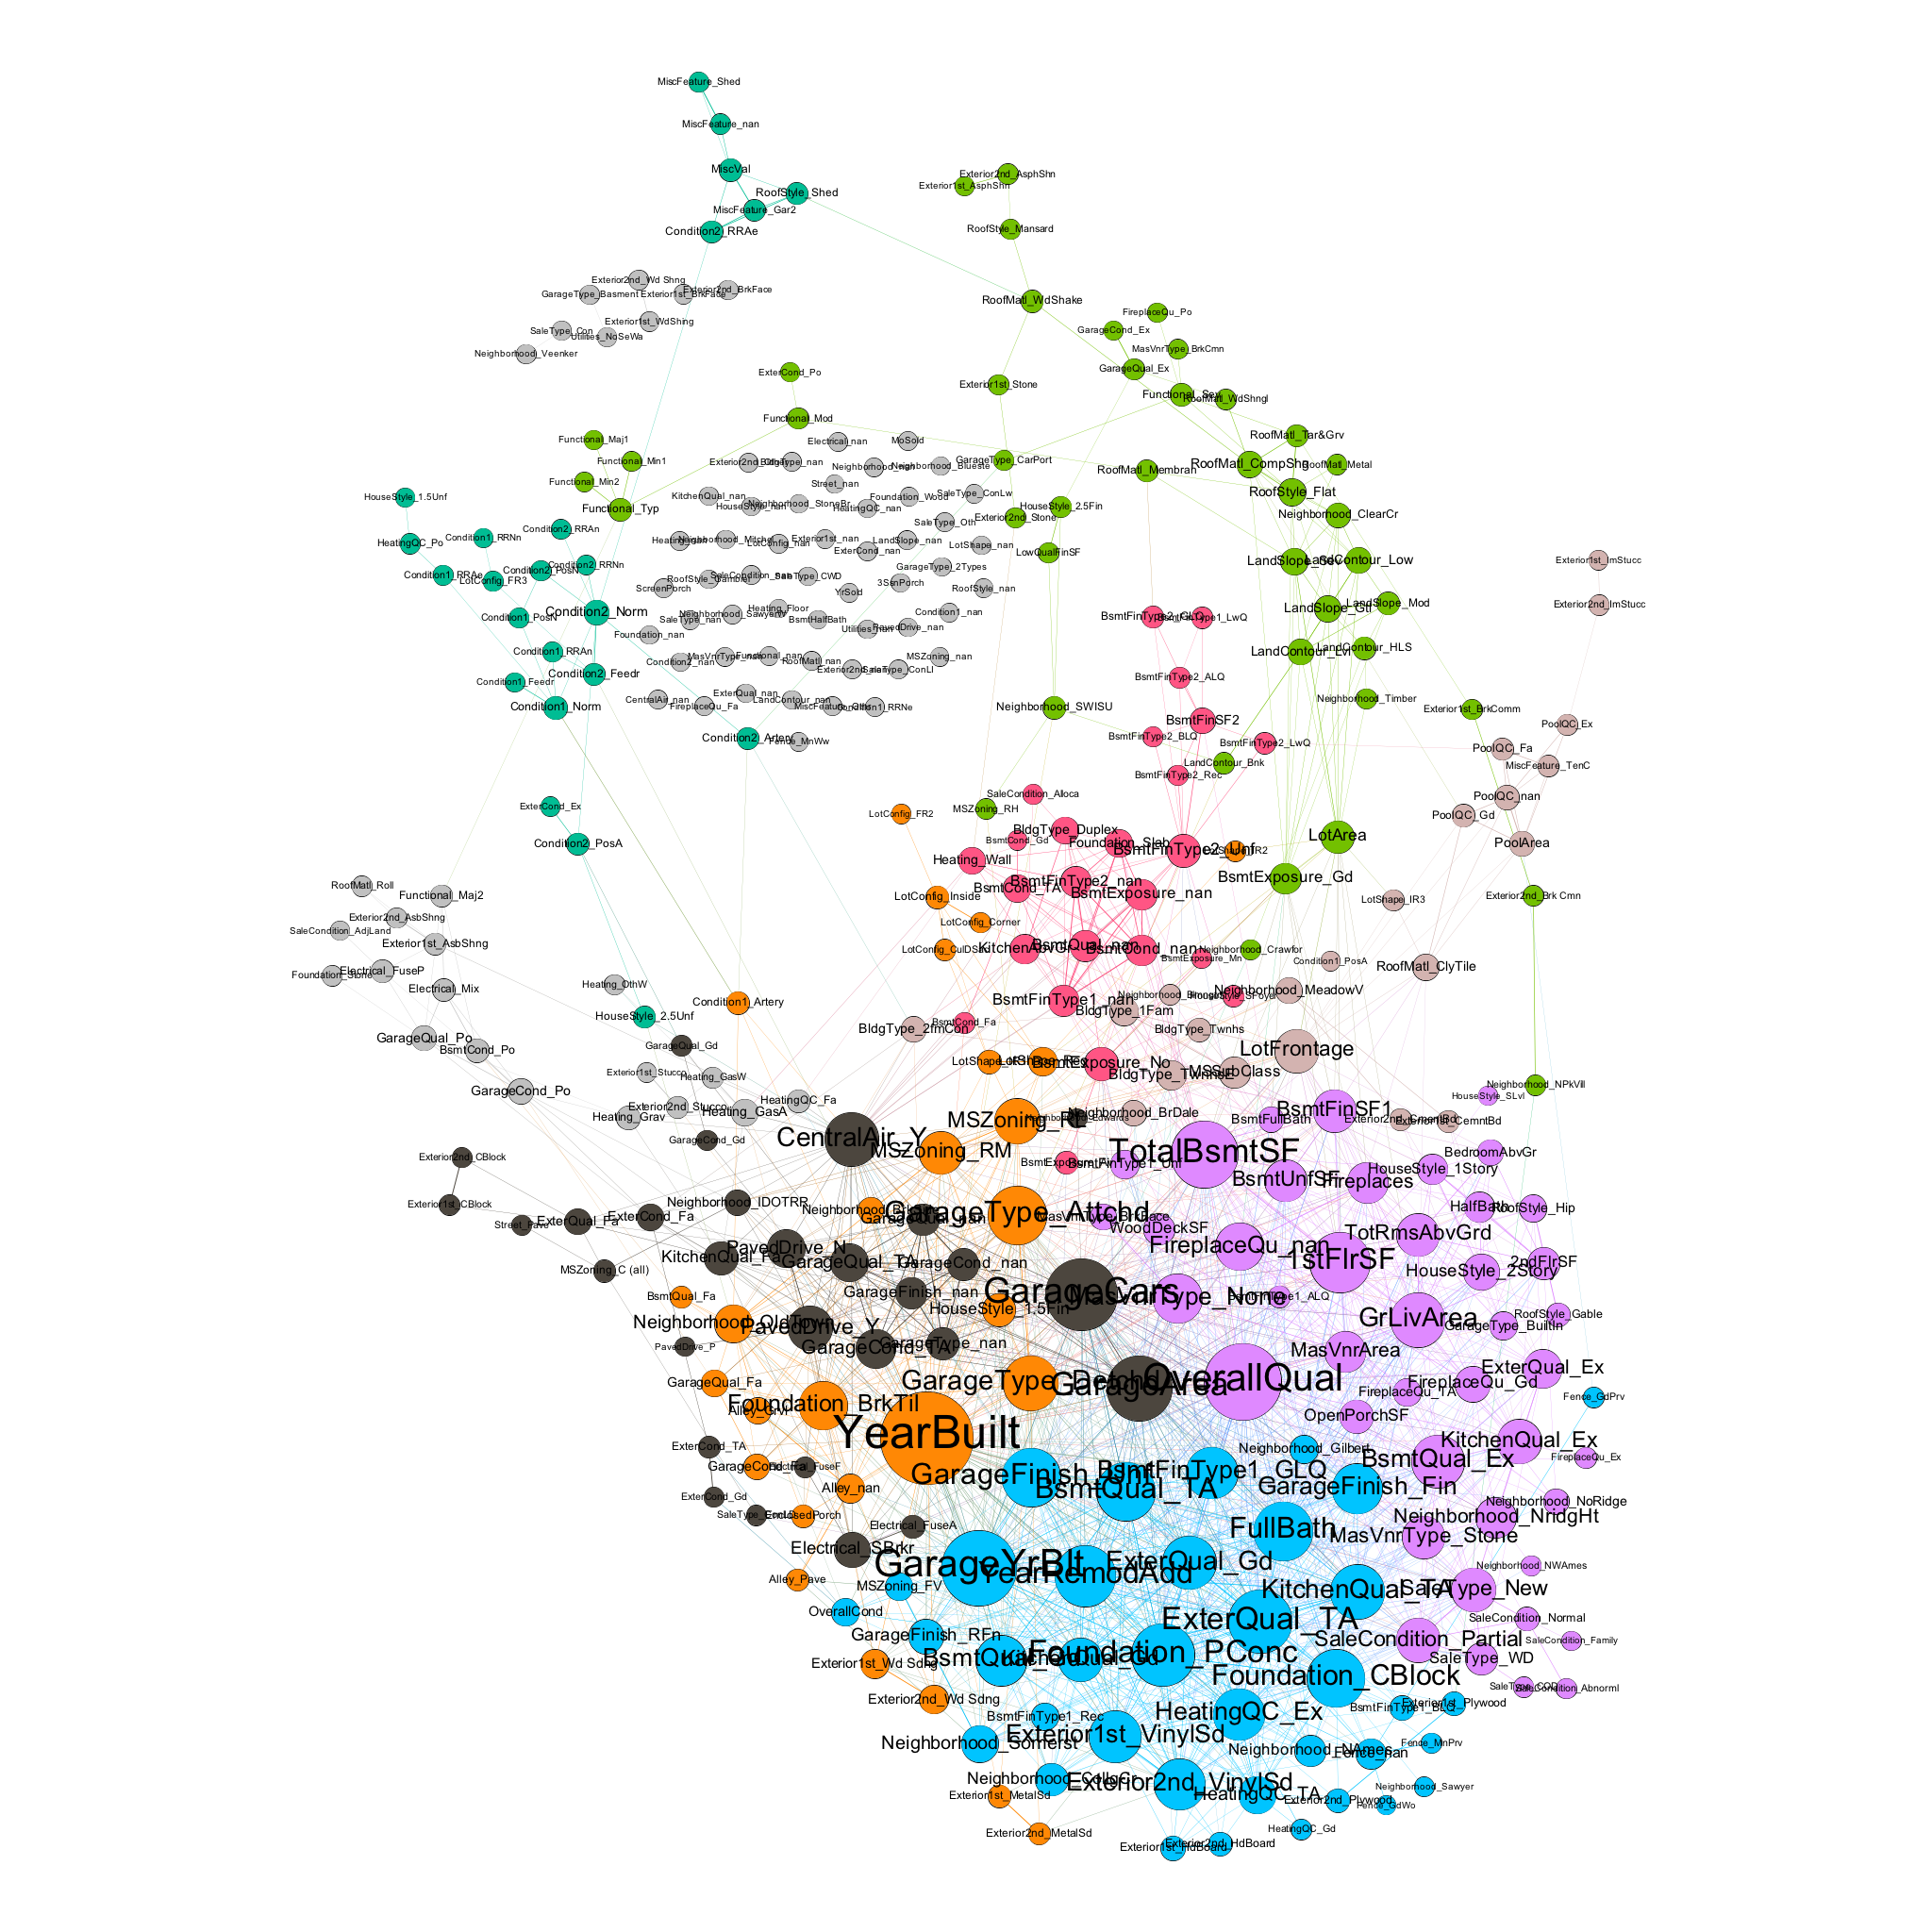

In [5]:
display(Image(('train.png')))